In [ ]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [313]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd
import datetime as dt

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from urllib.request import urlopen
from bs4 import BeautifulSoup


In [270]:
id = "0-20000-0-63772"

In [271]:
observedProperties = []
url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
xml = urlopen(url).read()
soup = BeautifulSoup(xml, 'xml')
content = soup('OAI-PMH')

with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    f.write(str(content))


with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    f.write(str(content))

In [272]:
# Establishment date of station

dateEstablished = soup.find_all('dateEstablished')
if dateEstablished:
    dateEstablished = re.findall(r'\d{4}-\d{2}-\d{2}',str(dateEstablished))[0]
else: 
    dateEstablished = "unknown"

print(dateEstablished)

1908-01-01


In [273]:
# get variables at a station

# find observed properties
observedProperties = []
with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
    observedProperties_line = soup.find_all('observedProperty')
    observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
    observedProperties.append(observedProperties_notation)

print(observedProperties)

from functools import reduce
# list of unique observed properties 
def unique(list1):
    ans = reduce(lambda re, x: re+[x] if x not in re else re, list1, [])
    return(ans)
variables_u = unique(observedProperties[0])


f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
lines=f.readlines()
all_dates = []

# prepare data frame #
df_station = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "dateEstablished", "variable"])

for var in variables_u:
    variable = var
    station = id

    # find line numbers containing the WMDR notation of the observed property
    numbers = []

    with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
        for num, line in enumerate(myFile, 1):
            if variable in line:
                numbers.append(num)

    # find the line numbers with <om:observedProperty
    obs = "observedProperty"
    numbers_obs = []

    for n in numbers:
        if obs in lines[n-1]:
            number = re.findall(r'\d+',lines[n-1])
            if number[0]==str(var):
                numbers_obs.append(n)

    ### read 50 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
    for n in numbers_obs:
        start = "beginPosition"
        end = "endPosition"
        line_numbers = range(n-50,n)

        f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
        lines=f.readlines()
        positions = []

        for n in line_numbers:
            if start in lines[n]:
                beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if beginning:
                    pd.to_datetime(beginning, format='%Y-%m-%d')
                    positions.append(beginning[0])
                else:
                    positions.append(np.nan)
                    
            elif end in lines[n]:
                ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                if ending:
                    pd.to_datetime(ending, format='%Y-%m-%d')
                    positions.append(ending[0])
                else: # if no ending: today
                    positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

        beginPosition  = positions[0]
        endPosition = positions[1]
        new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":station, "dateEstablished":dateEstablished, "variable":variable}
        df_station.loc[len(df_station)] = new_row 

    
df_station.drop([0], axis=0, inplace=True)
print(df_station)



[['179', '251', '265', '210', '266', '216', '216', '270', '224', '230', '12005', '12006', '531', '550', '510']]
   beginPosition endPosition          station dateEstablished variable
1     2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      179
2     2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      251
3     2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      265
4     2023-05-08  2023-11-15  0-20000-0-63772      1908-01-01      210
5     2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      266
6     2022-06-07  2023-11-15  0-20000-0-63772      1908-01-01      216
7     2023-04-30  2023-11-15  0-20000-0-63772      1908-01-01      216
8            NaN  2023-11-15  0-20000-0-63772      1908-01-01      270
9     2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      224
10    2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01      230
11    2016-04-29  2023-11-15  0-20000-0-63772      1908-01-01    12005
12    2016-04-29  2023-11-15  0-2000

In [274]:
with open(os.getcwd()+'/WMDR_dictionaries/'+'T_GO_VARIABLE_REF_dictionary.json') as f:
    dictionary = json.loads(f.read())

variables = df_station["variable"]

df_station["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]
df_station

,beginPosition,endPosition,station,dateEstablished,variable,variables_names
1,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,179,Cloud amount
2,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,251,Humidity (at specified distance from referenc...
3,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,265,Past weather
4,2023-05-08,2023-11-15,0-20000-0-63772,1908-01-01,210,Amount of precipitation
5,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,266,Present weather
6,2022-06-07,2023-11-15,0-20000-0-63772,1908-01-01,216,Atmospheric pressure
7,2023-04-30,2023-11-15,0-20000-0-63772,1908-01-01,216,Atmospheric pressure
8,NaN,2023-11-15,0-20000-0-63772,1908-01-01,270,Sunshine duration
9,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,224,Air temperature (at specified distance from re...
10,2016-04-29,2023-11-15,0-20000-0-63772,1908-01-01,230,Visibility


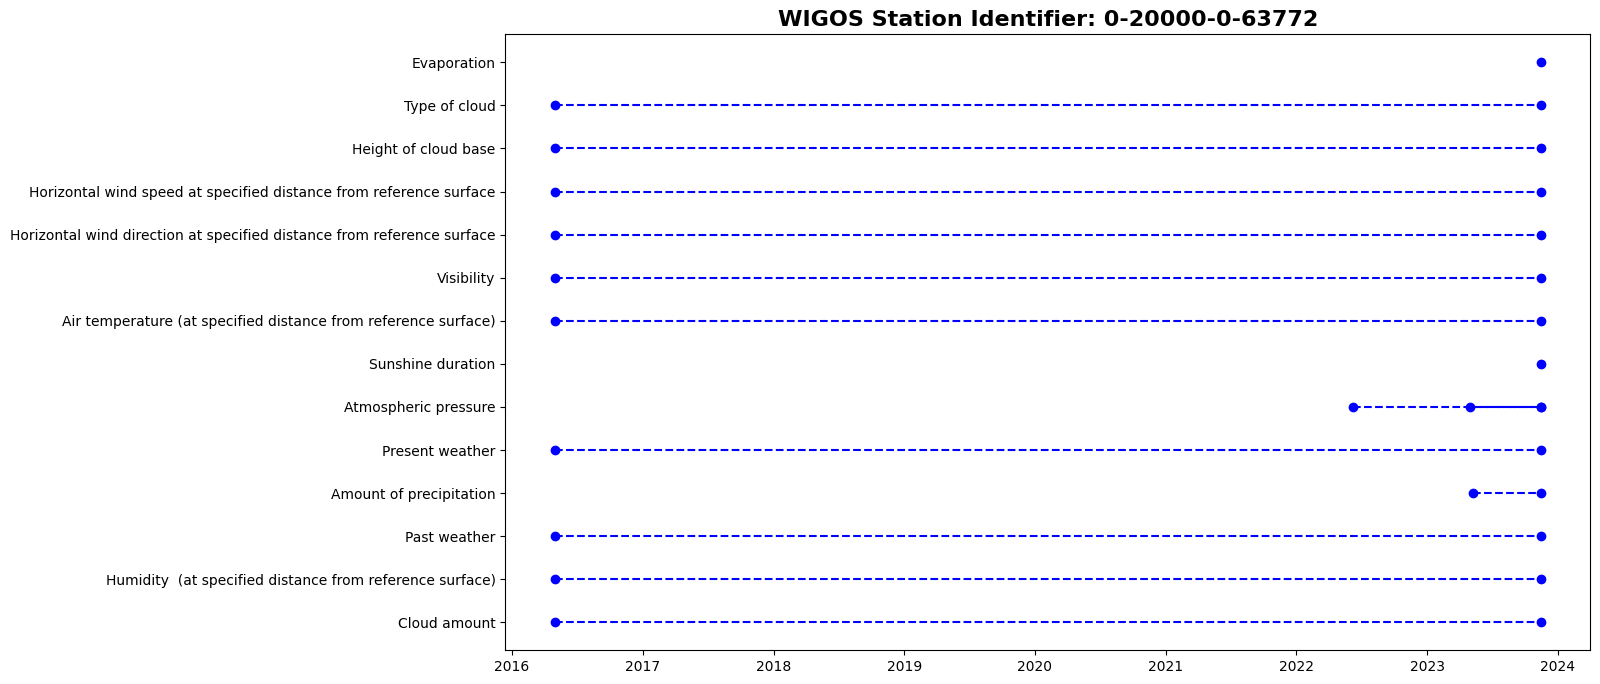

In [275]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,8))

variables = variables_u

for var in range(0,len(variables)):
    df_var = df_station[df_station["variable"]==str(variables[var])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    # print(x_values)
    plt.plot(x_values, [var,var], 'bo', linestyle="--")

# print(variables)
names = []
for var in range(0,len(variables)):
    variable_df = df_station[df_station["variable"]==str(variables[var])]
    name = variable_df.iloc[0]["variables_names"]
    # print(name)
    names.append(name)
n = range(0,len(names))
plt.yticks(n,names)

# title
plt.title("WIGOS Station Identifier: " + id, fontsize=16, fontweight="bold")


# save figure
fig.savefig(os.getcwd()+"/Plots/Deployments_"+id+".jpeg", bbox_inches='tight')

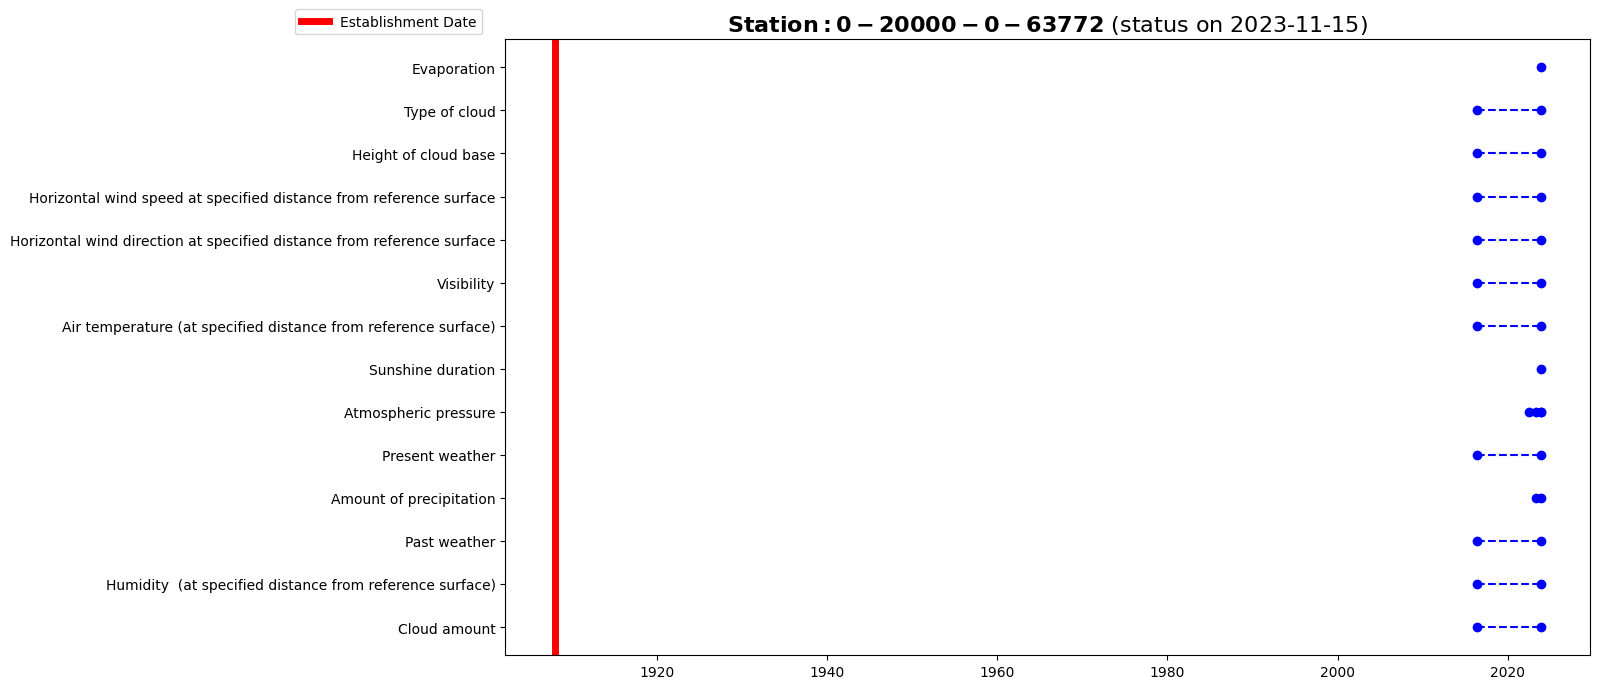

In [276]:
# include establishment date

plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,8))

variables = variables_u

for var in range(0,len(variables)):
    df_var = df_station[df_station["variable"]==str(variables[var])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    # print(x_values)
    plt.plot(x_values, [var,var], 'bo', linestyle="--")
    

# line for establishment date
est_date = [pd.to_datetime(df_var["dateEstablished"])]
plt.axvline(x=est_date, c="red", linewidth=5, label= "Establishment Date")

# print(variables)
names = []
for var in range(0,len(variables)):
    variable_df = df_station[df_station["variable"]==str(variables[var])]
    name = variable_df.iloc[0]["variables_names"]
    # print(name)
    names.append(name)
n = range(0,len(names))
plt.yticks(n,names)

# title
# from matplotlib import rc
# rc('text', usetex=True)
# fontsize=16, fontweight="bold"
plt.title(r'$\bf{Station: ' + id+'}$' + ' (status on ' + pd.Timestamp.today().strftime("%Y-%m-%d") + ')', fontsize=16)

# legend
plt.legend(loc="upper left", fontsize=10, scatterpoints=25, bbox_to_anchor=(-0.2, 1.06))


# save figure
fig.savefig(os.getcwd()+"/Plots/Deployments_"+id+"_withEstablishmentDate.jpeg", bbox_inches='tight')